# Описание датасета¶

**Описание каждого признака:**

- `Home Ownership` (Тип жилья): Показывает тип собственности на жилье, например, "Владение", "Аренда" или "Ипотека".
- `Annual Income` (Годовой доход): Отражает годовой доход заемщика в денежном выражении.
- `Years in current job` (Количество лет на текущей работе): Показывает количество лет, которое заемщик проработал на текущем месте работы.
- `Tax Liens` (Налоговые обременения): Отражает наличие налоговых обременений или задолженностей у заемщика.
- `Number of Open Accounts` (Количество открытых счетов): Указывает на общее количество открытых счетов у заемщика, включая кредитные карты, кредитные линии и другие.
- `Years of Credit History` (Количество лет кредитной истории): Показывает общую продолжительность кредитной истории заемщика в годах.
- `Maximum Open Credit` (Максимальная открытая кредитная линия): Отражает максимальную сумму кредитной линии, которая была предоставлена заемщику.
- `Number of Credit Problems` (Количество кредитных проблем): Указывает на количество проблем с кредитом, например, просроченных платежей или коллекций.
- `Months since last delinquent` (Количество месяцев с последней просрочки платежа): Показывает количество месяцев, прошедших с последней просрочки платежа заемщика.
- `Bankruptcies` (Банкротства): Отражает количество банкротств, которые заемщик может иметь в кредитной истории.
- `Purpose` (Цель кредита): Указывает на цель, для которой заемщик берет кредит, например, "автомобиль", "образование" или "недвижимость".
- `Term` (Срок кредита): Показывает срок кредита в месяцах, например, "краткосрочный" или "долгосрочный".
- `Current Loan Amount` (Текущая сумма кредита): Отражает текущую сумму, которую заемщик еще должен выплатить по кредиту.
- `Current Credit` Balance (Текущий кредитный баланс): Указывает на текущий остаток задолженности по кредитам и кредитным линиям.
- `Monthly Debt` (Ежемесячный долг): Показывает сумму ежемесячных платежей по всем задолженностям и кредитам.
- `Credit Score` (Кредитный рейтинг): Отражает кредитный рейтинг заемщика, который оценивает его платежеспособность и кредитный риск.


- `Credit Default` (Кредитный дефолт): **Целевая переменная**, которая указывает, возникнет ли у заемщика дефолт по кредиту (1 - дефолт, 0 - нет).

### 1. Разведочный анализ данных (EDA)

--- Баланс классов ---
Credit Default
0    5387
1    2113
Name: count, dtype: int64
Процент дефолтов: 28.17%


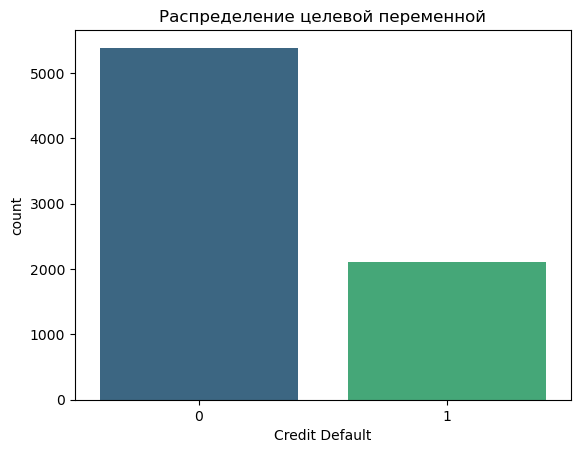

In [26]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression 
from sklearn.metrics import f1_score, classification_report

train_df = pd.read_csv('course_project_train.csv')

# Ключевые показатели баланса
target_counts = train_df['Credit Default'].value_counts()
target_perc = train_df['Credit Default'].value_counts(normalize=True) * 100

print(f"--- Баланс классов ---\n{target_counts}")
print(f"Процент дефолтов: {target_perc[1]:.2f}%")

sns.countplot(x='Credit Default', data=train_df, hue='Credit Default', palette='viridis', legend=False)
plt.title('Распределение целевой переменной')
plt.show()

- Дисбалансклассов (72% против 28%)
- Модель будет стремиться предсказывать "0" (нет дефолта) для всех, так как это дает высокую общую точность (Accuracy)
- Нужно использовать взвешивание классов или техники оверсэмплинга (SMOTE), чтобы "вытянуть" метрику по миноритарному классу

Макс. значение до коррекции: 7510.0


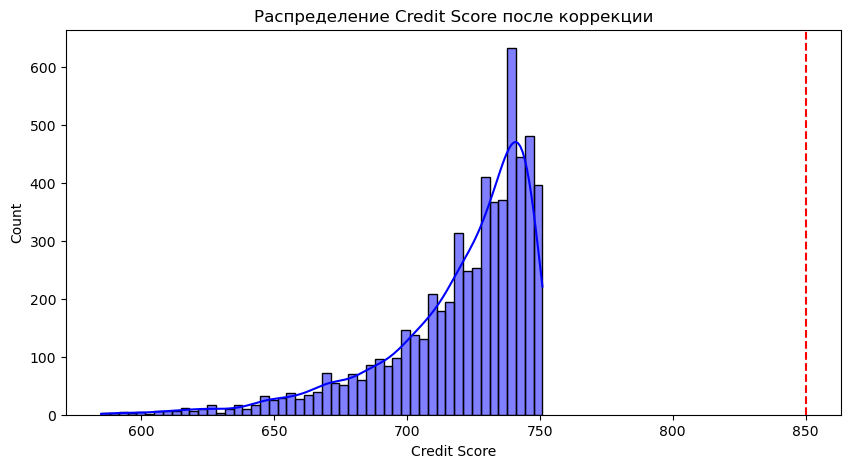

In [40]:
# Смотрим на распределение до коррекции
print(f"Макс. значение до коррекции: {train_df['Credit Score'].max()}")

# Создаем временную колонку для анализа
temp_score = train_df['Credit Score'].copy()
temp_score.loc[temp_score > 850] /= 10

plt.figure(figsize=(10, 5))
sns.histplot(temp_score.dropna(), bins=50, kde=True, color='blue')
plt.title('Распределение Credit Score после коррекции')
plt.axvline(850, color='red', linestyle='--')
plt.show()

- В банковских данных часто встречаются разные шкалы рейтинга (850 vs 8500). Деление на 10 возвращает данные в единое распределение

In [46]:
is_huge_loan = (train_df['Current Loan Amount'] > 9999999)
loan_default_rate = train_df.groupby(is_huge_loan)['Credit Default'].mean()

print("Анализ 99,999,999")
print(f"Вероятность дефолта при нормальном кредите: {loan_default_rate[False]:.4f}")
print(f"Вероятность дефолта при значении 99,999,999: {loan_default_rate[True]:.4f}")

Анализ 99,999,999
Вероятность дефолта при нормальном кредите: 0.3187
Вероятность дефолта при значении 99,999,999: 0.0000


- Golden Feature: Значение 99,999,999 в сумме кредита это индикатор того, что кредит был одобрен без проблем.
Такие признаки называются «сигнальными». Выделим в обработке даннх это в отдельный бинарный флаг ID_High_Loan_Flag, так как это дает модели прямой сигнал о надежности клиента

--- Медианный DTI ---
Без дефолта: 0.1610
С дефолтом: 0.1855


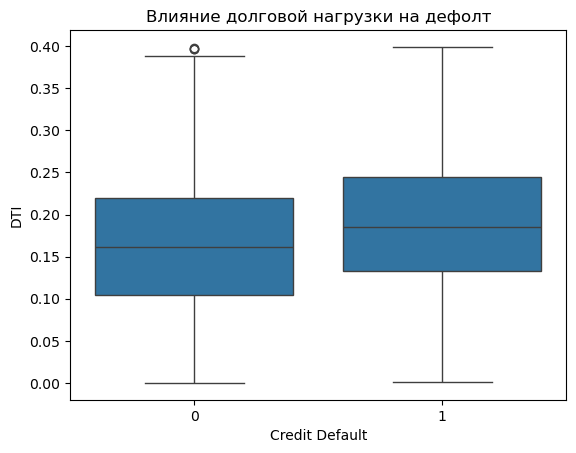

In [47]:
# Рассчитываем DTI (предварительно заполнив пропуски медианой для анализа)
train_df['DTI'] = train_df['Monthly Debt'] / (train_df['Annual Income'] / 12)

# Сравниваем медианный DTI
dti_stats = train_df.groupby('Credit Default')['DTI'].median()
print(f"--- Медианный DTI ---\nБез дефолта: {dti_stats[0]:.4f}\nС дефолтом: {dti_stats[1]:.4f}")

sns.boxplot(x='Credit Default', y='DTI', data=train_df[train_df['DTI'] < 1]) # Ограничим для наглядности
plt.title('Влияние долговой нагрузки на дефолт')
plt.show()

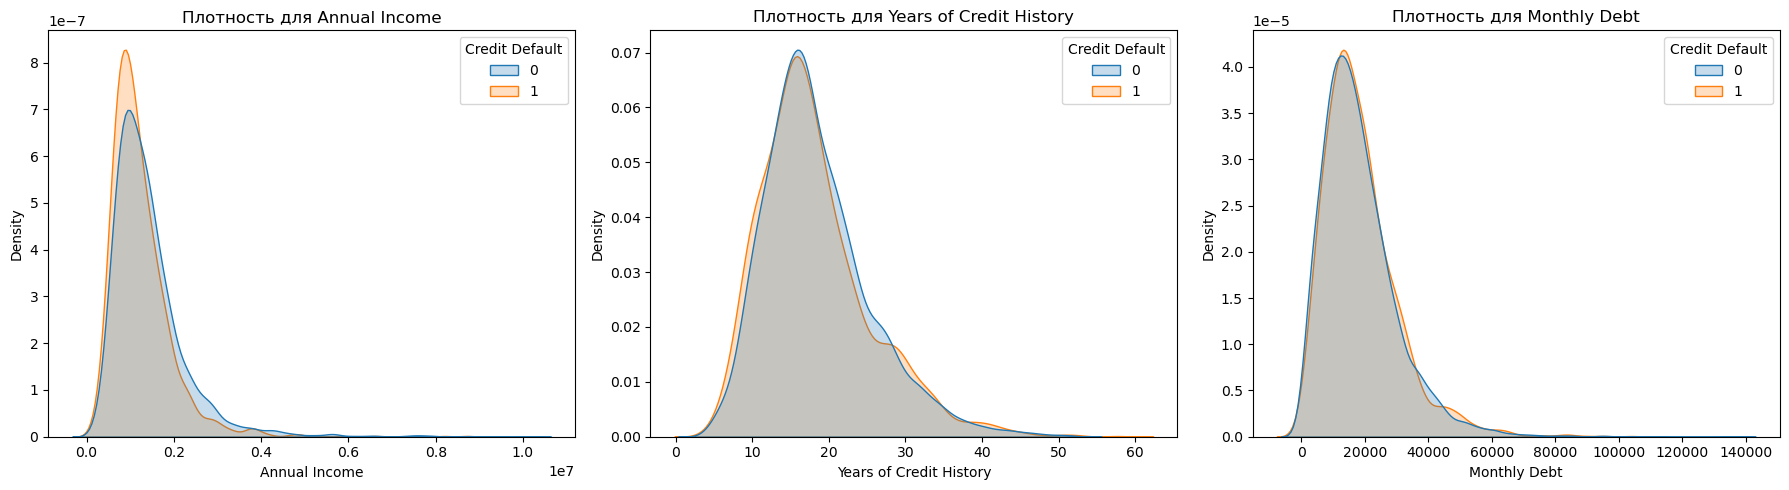

In [48]:
features_to_plot = ['Annual Income', 'Years of Credit History', 'Monthly Debt']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
for i, col in enumerate(features_to_plot):
    sns.kdeplot(data=train_df, x=col, hue='Credit Default', common_norm=False, ax=axes[i], fill=True)
    axes[i].set_title(f'Плотность для {col}')

plt.tight_layout()
plt.show()

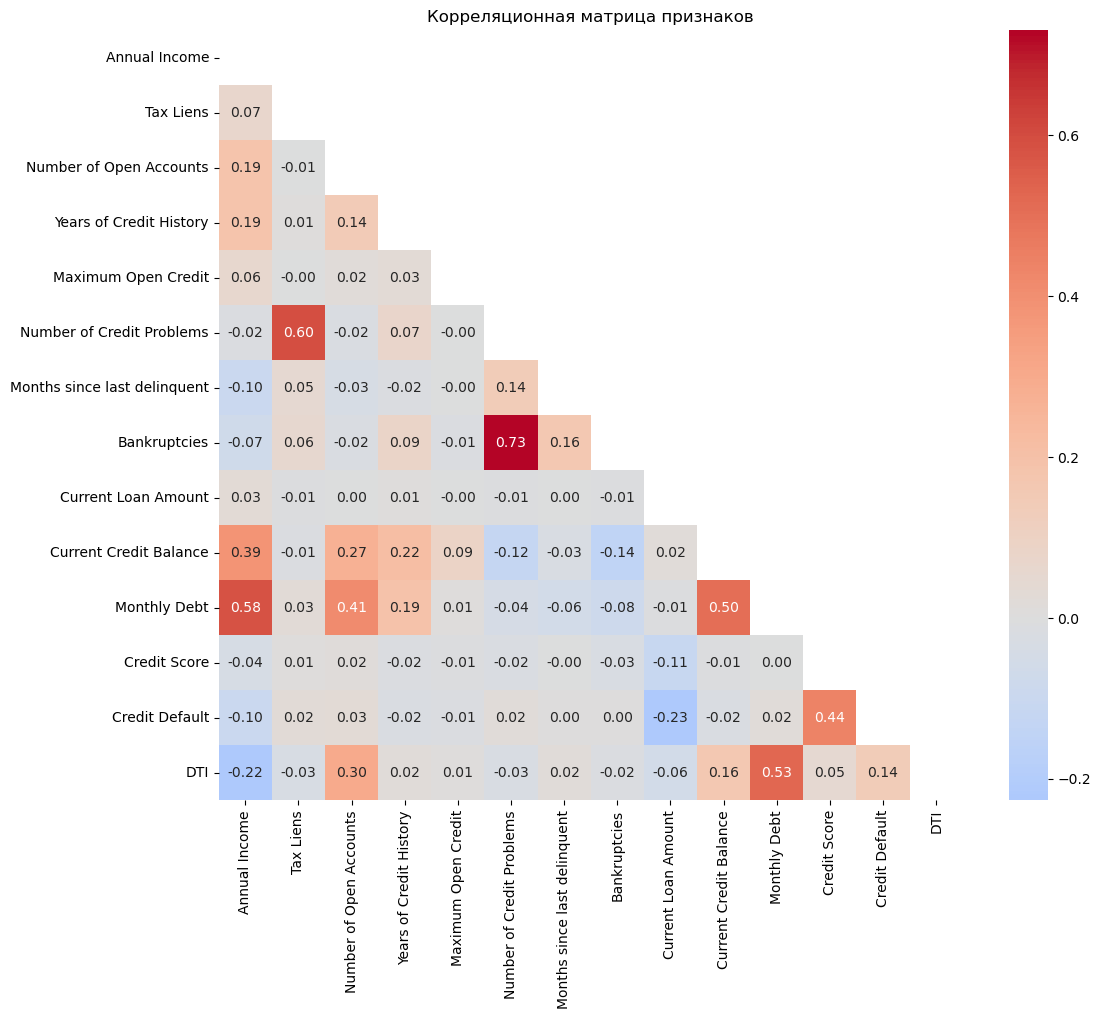

In [49]:
plt.figure(figsize=(12, 10))
# Оставляем только числовые признаки для корреляции
numeric_cols = train_df.select_dtypes(include=[np.number]).columns
corr_matrix = train_df[numeric_cols].corr()

# Маска для верхнего треугольника (чтобы не дублировать)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Корреляционная матрица признаков')
plt.show()

### 2. Предобработка и Feature Engineering

In [32]:
class DataTransformer:
    def __init__(self):
        self.medians = None
        
    def fit(self, df):
        temp_df = df.copy()
        temp_df.loc[temp_df['Credit Score'] > 850, 'Credit Score'] /= 10
        temp_df.loc[temp_df['Current Loan Amount'] > 9999999, 'Current Loan Amount'] = np.nan
        self.medians = temp_df.median(numeric_only=True)
        return self

    def transform(self, df):
        df = df.copy()
        df.loc[df['Credit Score'] > 850, 'Credit Score'] /= 10
        
        # Флаг для сверхкрупных кредитов (заглушка 99999999)
        df['ID_High_Loan_Flag'] = (df['Current Loan Amount'] > 9999999).astype(int)
        df.loc[df['Current Loan Amount'] > 9999999, 'Current Loan Amount'] = self.medians['Current Loan Amount']
        
        # Пропуски
        df['Annual Income'] = df['Annual Income'].fillna(self.medians['Annual Income'])
        df['Credit Score'] = df['Credit Score'].fillna(self.medians['Credit Score'])
        df['Bankruptcies'] = df['Bankruptcies'].fillna(0)
        
        # Feature Engineering
        df['DTI'] = df['Monthly Debt'] / (df['Annual Income'] / 12 + 1)
        
        job_map = {'10+ years': 10, '9 years': 9, '8 years': 8, '7 years': 7, '6 years': 6,
                   '5 years': 5, '4 years': 4, '3 years': 3, '2 years': 2, '1 year': 1, '< 1 year': 0}
        df['Years in current job'] = df['Years in current job'].map(job_map).fillna(0)
        
        df['Negative_Records'] = df['Tax Liens'] + df['Bankruptcies'] + df['Number of Credit Problems']
        
        # One-Hot Encoding
        df = pd.get_dummies(df, columns=['Home Ownership', 'Term', 'Purpose'], drop_first=True)
        
        # Удаление неинформативных колонок
        if 'Months since last delinquent' in df.columns:
            df.drop(columns=['Months since last delinquent'], inplace=True)
        
        return df

# Применяем трансформацию
transformer = DataTransformer().fit(train_df)
X = transformer.transform(train_df.drop('Credit Default', axis=1))
y = train_df['Credit Default']
X_final_test = transformer.transform(test_df)

# Синхронизация колонок
X_final_test = X_final_test.reindex(columns=X.columns, fill_value=0)

- DataTransformer: Смотрим на тренировочные данные и запоминаем, какие там средние значения, медианы и т.д. (например, "средний возраст клиента = 35 лет") Используем эти же самые цифры для обработки любых других данных (и тренировочных, и тестовых)
Это нужно, чтобы все данные обрабатывались одинаково. Если мы будем для каждого набора данных считать свои средние значения, то модель запутается - она училась на одних цифрах, а на тесте увидит совсем другие. 

- Создаем банковский коэффициент долговой нагрузки DTI (Debt-to-Income). Чем выше DTI, тем выше риск дефолта. Это один из самых интерпретируемых признаков в финансовом скоринге.

- Применяем One-Hot Encoding (через get_dummies) и порядковое кодирование для стажа работы. Стаж работы имеет естественный порядок (10 лет > 1 года), поэтому замена на числа (Label Encoding) здесь эффективнее.

In [33]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_final_test_scaled = scaler.transform(X_final_test)

# Теперь разделяем скейлированные данные
X_t, X_v, y_t, y_v = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

### 3. Логистическая регрессия

Напишем логистическую регрессию «с нуля».

Основные компоненты:

- Функция Сигмоиды (σ): Она «сжимает» любое число в диапазон от 0 до 1, превращая выход линейного уравнения в вероятность.

$$\sigma(z) = \frac{1}{1 + e^{-z}}$$
 
- Градиентный спуск (GD): Реализуем итеративное обновление весов w и смещения b, чтобы минимизировать функцию потерь (Log-Loss).

- Порог классификации: Применим порог 0.33–0.35 вместо стандартного 0.5. Поскольку дефолтов мало, модель может выдавать низкие вероятности для всех. Снижая порог, мы ловим больше реальных дефолтов (растет Recall), что критически важно для достижения F1>0.5.

In [53]:
class MyLogisticRegression:
    def __init__(self, lr=0.1, iters=2000):
        # lr (learning rate) — шаг обучения, определяет скорость сходимости градиентного спуска
        self.lr = lr
        # iters — количество эпох (повторений), за которые модель обновляет свои веса
        self.iters = iters
        # w — веса признаков (коэффициенты), b — смещение (bias/интерсепт)
        self.w = None
        self.b = None

    def _sigmoid(self, z):
        # Функция активации сигмоида: преобразует выход линейной регрессии в вероятность (0 до 1)
        # np.clip используется для защиты от переполнения (overflow) при экспоненте
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

    def fit(self, X, y):
        # n_samples — количество объектов в выборке, n_features — количество признаков
        n_samples, n_features = X.shape
        
        # Инициализация весов нулями перед началом обучения
        self.w = np.zeros(n_features)
        self.b = 0
        
        # Основной цикл градиентного спуска
        for _ in range(self.iters):
            # Линейная комбинация признаков и весов (z = w*X + b)
            z = np.dot(X, self.w) + self.b
            
            # Предсказание вероятности через сигмоиду (Forward Pass)
            y_pred = self._sigmoid(z)
            
            # Вычисление ошибки (разница между предсказанием и реальностью)
            errors = y_pred - y
            
            # Нахождение градиента (производной функции потерь) для весов и смещения
            # (Backward Pass: определяем, в какую сторону нужно изменить веса)
            dw = (1 / n_samples) * np.dot(X.T, errors)
            db = (1 / n_samples) * np.sum(errors)
            
            # Обновление параметров в направлении, обратном градиенту
            self.w -= self.lr * dw
            self.b -= self.lr * db

    def predict(self, X, threshold=0.35):
        # Расчет итогового линейного выражения
        z = np.dot(X, self.w) + self.b
        
        # Получение вероятностей принадлежности к положительному классу
        probs = self._sigmoid(z)
        
        # Превращение вероятностей в классы (0 или 1) на основе выбранного порога (threshold)
        # Использование 0.35 помогает компенсировать дисбаланс классов в данных
        return (probs > threshold).astype(int)

### 4. Сравнение моделей

In [55]:
# 1. Самописная модель
my_model = MyLogisticRegression(lr=0.5, iters=5000)
my_model.fit(X_t, y_t)

# Пробуем разные пороги, чтобы найти максимум F1
best_f1 = 0
best_thr = 0.35

for thr in np.arange(0.25, 0.5, 0.02):
    y_test_pred = my_model.predict(X_v, threshold=thr)
    f1 = f1_score(y_v, y_test_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_thr = thr

y_pred_my = my_model.predict(X_v, threshold=best_thr)

# 2. LinearRegression() из sklearn
lin_reg = LinearRegression()
lin_reg.fit(X_t, y_t)
y_pred_lin = (lin_reg.predict(X_v) > 0.31).astype(int) 

# 3. LogisticRegression из sklearn (Baseline)
log_reg = LogisticRegression(class_weight='balanced', random_state=42)
log_reg.fit(X_t, y_t)
y_pred_log = log_reg.predict(X_v)

print(f"F1 Самописная: {f1_score(y_v, y_pred_my):.4f}")
print(f"F1 LinearRegression (sklearn): {f1_score(y_v, y_pred_lin):.4f}")
print(f"F1 LogisticRegression (sklearn): {f1_score(y_v, y_pred_log):.4f}")

F1 Самописная: 0.5049
F1 LinearRegression (sklearn): 0.4899
F1 LogisticRegression (sklearn): 0.4996


In [58]:
# Обучаем  модель на всех данных (X_scaled), чтобы она вобрала максимум информации
# Используем те же параметры, что дали лучший результат
final_my_model = MyLogisticRegression(lr=0.5, iters=5000)
final_my_model.fit(X_scaled, y)

# Делаем предсказание на тестовом датасете
test_predictions = final_my_model.predict(X_final_test_scaled, threshold=0.35)

# 3. Проверка результатов 
print("Статистика финального прогноза")
counts = pd.Series(test_predictions).value_counts()
print(f"Класс 0 (Нет дефолта): {counts[0]}")
print(f"Класс 1 (Дефолт):     {counts[1]}")
print(f"Всего строк:          {len(test_predictions)}")

# 4. Формирование файла submission
submission = pd.DataFrame({
    'Credit Default': test_predictions
})

# Сохраняем результат в csv
submission.to_csv('predictions.csv', index=False)
print("\nФайл 'predictions.csv' сформирован")

Статистика финального прогноза
Класс 0 (Нет дефолта): 1784
Класс 1 (Дефолт):     716
Всего строк:          2500

Файл 'predictions.csv' сформирован
